In [48]:
import html
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from contractions import fix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.add("escapenumber")
email_pattern = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
phone_pattern = re.compile(r'\+?\b\d+[\d\s.-]{5,}\b')


In [3]:
with open('spam_email_dataset.csv') as file:
    data = pd.read_csv(file)
    
data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [28]:
def preprocess_text(text):
    """
Функция производит предобработку текста письма:
- обрабатывает HTML-сущности;
- нормализует специальные шаблоны электронной почты;
- проводит углублённую очистку текста;
- удаляет стоп-слова с учётом контекста.
"""

    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    
    try:
        text = html.unescape(text)
        text = text.lower()
        text = fix(text)
        text = email_pattern.sub('EMAIL_ADDR', text)
        text = url_pattern.sub('HTTP_URL', text)
        text = phone_pattern.sub('PHONE_NUM', text)
        text = re.sub(r'[^a-z\s.!?\']', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        words = word_tokenize(text)
        
        processed_words = []
        for word in words:
            word = re.sub(r'[^\w.!?\']', '', word)
            if word in {'http_url', 'email_addr', 'phone_num'}:
                processed_words.append(word)
                continue
            if word in stop_words:
                continue
            lemma = lemmatizer.lemmatize(word)
            processed_words.append(lemma)
        
        return ' '.join(processed_words)
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return ""

In [49]:
data['text'] = data['text'].apply(preprocess_text)
data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection cnn com wednesday may pm e...
3,1,university degree obtain prosperous future mon...
4,0,thanks answer guy know checked rsync manual wo...


In [50]:
def build_tokenizer(email_data, max_features=20000, sequence_length=100):
    """
Создаёт слой токенизатора TextVectorization для набора данных электронных писем.

Parameters:
    email_data (list, str): список текстов электронных писем, если получена строка, преобразует к списку.
    max_features (int): максимальный размер словаря.
    sequence_length (int): длина выходных последовательностей после дополнения или усечения.

Returns:
    vectorize_layer (tf.keras.layers.TextVectorization): сконфигурированный слой токенизатора.
"""
    if isinstance(email_data, str):
        email_data = [email_data]
        
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_features, 
        output_mode='int',        
        output_sequence_length=sequence_length, 
        standardize=None  
    )

    vectorize_layer.adapt(email_data)

    return vectorize_layer


def tokenize_emails(email_data, vectorize_layer):
    """
Токенизирует список электронных писем, используя предварительно созданный слой TextVectorization.

Parameters:
    email_data (list, str): список текстов электронных писем.
    vectorize_layer (tf.keras.layers.TextVectorization): предварительно созданный слой токенизатора.

Returns:
    tokenized_output (np.ndarray): токенизированные и дополненные последовательности в виде массива NumPy.
"""
    if isinstance(email_data, str):
        email_data = [email_data]

    tokenized_output = vectorize_layer(email_data).numpy()
    tokenized_output = np.array(tokenized_output, dtype=np.int32)
    return tokenized_output

In [51]:
vectorized_data = data.copy()
tokenizer = build_tokenizer(data['text'])

texts = data['text'].values

tokenized_texts = tokenize_emails(texts, tokenizer)


In [52]:
# делим на 3 выборки
X = X = np.array(tokenized_texts, dtype=np.int32) 
y = vectorized_data['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.4, 
    random_state=42,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,  
    random_state=42,
)

In [53]:
# собираем сверточную нейросеть
model = models.Sequential([
    layers.Embedding(input_dim=20000, output_dim=16),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

history = model.fit(
    X_train, y_train, 
    epochs=7, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1
)

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

Epoch 1/7
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9326 - auc_4: 0.9744 - loss: 0.1566 - precision_4: 0.9215 - recall_4: 0.9575 - val_accuracy: 0.9817 - val_auc_4: 0.9978 - val_loss: 0.0515 - val_precision_4: 0.9831 - val_recall_4: 0.9821
Epoch 2/7
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9903 - auc_4: 0.9984 - loss: 0.0309 - precision_4: 0.9878 - recall_4: 0.9937 - val_accuracy: 0.9819 - val_auc_4: 0.9978 - val_loss: 0.0493 - val_precision_4: 0.9752 - val_recall_4: 0.9908
Epoch 3/7
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9930 - auc_4: 0.9991 - loss: 0.0227 - precision_4: 0.9911 - recall_4: 0.9955 - val_accuracy: 0.9809 - val_auc_4: 0.9963 - val_loss: 0.0706 - val_precision_4: 0.9873 - val_recall_4: 0.9763
Epoch 4/7
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9954 - auc_4: 0.9996 - loss: 0.0136 - precision_4: 0.9938 - recall_4: 0.9975 - val_accuracy: 0.9799 - val_auc_4: 0.9961 - val_loss: 0.0634 - val_precision_4: 0.9748 - 

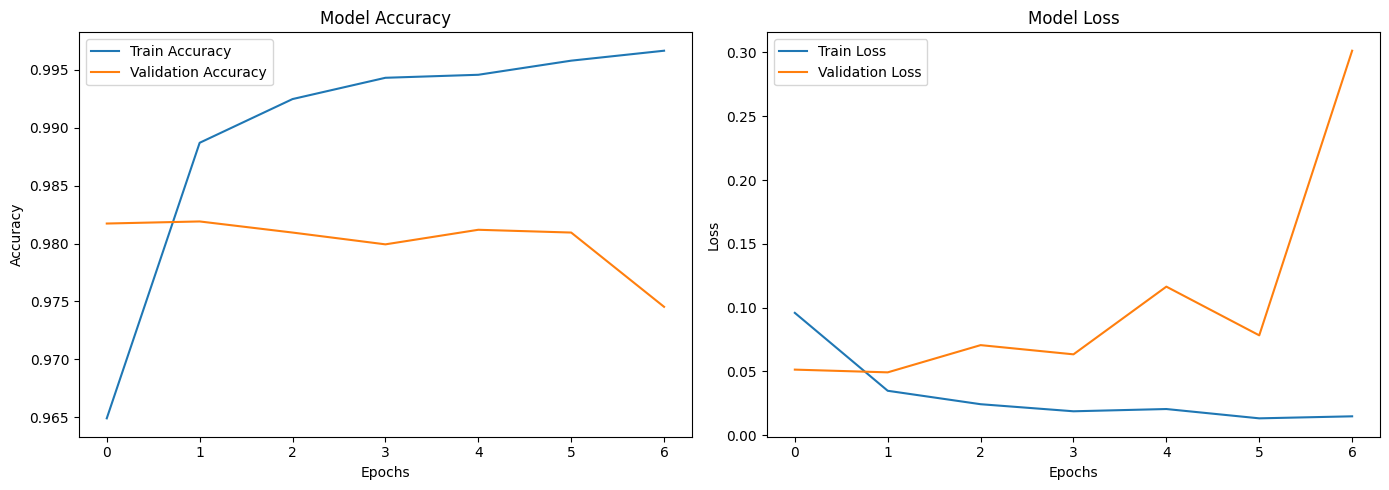

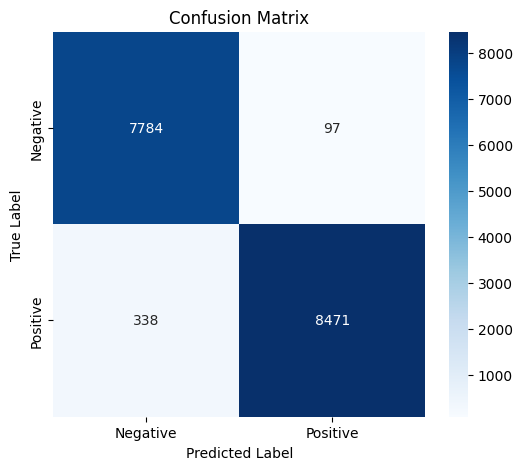

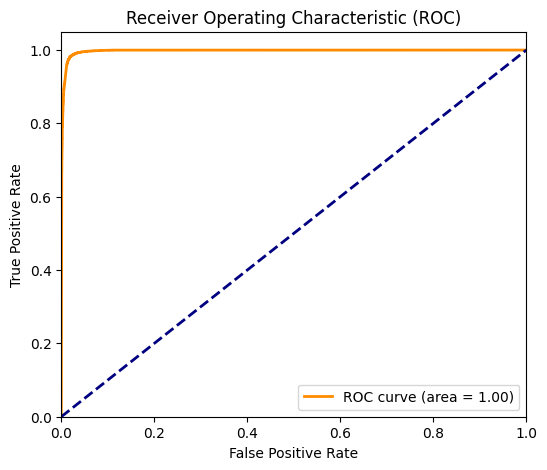

Classification Report:
              precision    recall  f1-score       support
Negative       0.958385  0.987692  0.972818   7881.000000
Positive       0.988679  0.961630  0.974967   8809.000000
accuracy       0.973936  0.973936  0.973936      0.973936
macro avg      0.973532  0.974661  0.973892  16690.000000
weighted avg   0.974374  0.973936  0.973952  16690.000000


In [55]:
# 1. Графики accuracy и loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 4. Отчет о классификации
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).T
print("Classification Report:")
print(report_df)

## Возникла проблема переобучения, что видно на графике валидационной выборки, да и в целом модель слишком бодро стартует в точности с первой же эпохи. Очевидна проблема в том, что точность модели на валидационной выборке нестабильна и даже падает с обучением
### Попробуем поработать с настройкой гиперпараметров и использовать различные методы для оптимизации - dropout, early stopping, l2-regularization. Все они помогают справиться с проблемой переобучения. 
- **Dropout** случайным образом выключает некоторые нейроны в слое, чтобы модель использовала все нейроны, а не полагалась на несколько, к тому же это помогает справляться с зашумленными данными. 
- **Early stopping** останавливает обучение, когда модель перестает показывать улучшение по на валидационной выборке. Это очень помогает предотвратить выучивание данных наизусть и ускоряет обучение. 
- **L2 Regularization** мотивирует модель держать значения весов пониже, если только они не супер важны. Это тоже предотвращает переобучение и помогает генерализировать данные. 

Также была уменьшена скорость обучения до одной тысячной и добавлено больше эпох, все равно есть early stopping, вдруг модель станет еще эффективнее.


In [56]:
model = models.Sequential([
    layers.Embedding(input_dim=20000, output_dim=16),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Dropout(0.5),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)


history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

Epoch 1/20
783/783 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5453 - auc_5: 0.5686 - loss: 1.1850 - precision_5: 0.5549 - recall_5: 0.6559 - val_accuracy: 0.9007 - val_auc_5: 0.9602 - val_loss: 0.6144 - val_precision_5: 0.9228 - val_recall_5: 0.8851
Epoch 2/20
783/783 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9125 - auc_5: 0.9628 - loss: 0.4476 - precision_5: 0.8995 - recall_5: 0.9386 - val_accuracy: 0.9664 - val_auc_5: 0.9939 - val_loss: 0.2095 - val_precision_5: 0.9693 - val_recall_5: 0.9667
Epoch 3/20
783/783 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9662 - auc_5: 0.9931 - loss: 0.1820 - precision_5: 0.9588 - recall_5: 0.9776 - val_accuracy: 0.9731 - val_auc_5: 0.9962 - val_loss: 0.1251 - val_precision_5: 0.9715 - val_recall_5: 0.9775
Epoch 4/20
783/783 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9750 - auc_5: 0.9958 - loss: 0.1130 - precision_5: 0.9700 - recall_5: 0.9826 - val_accuracy: 0.9762 - val_auc_5: 0.9969 - val_loss: 0.0940 - val_precision_5: 0.9757 - val_r

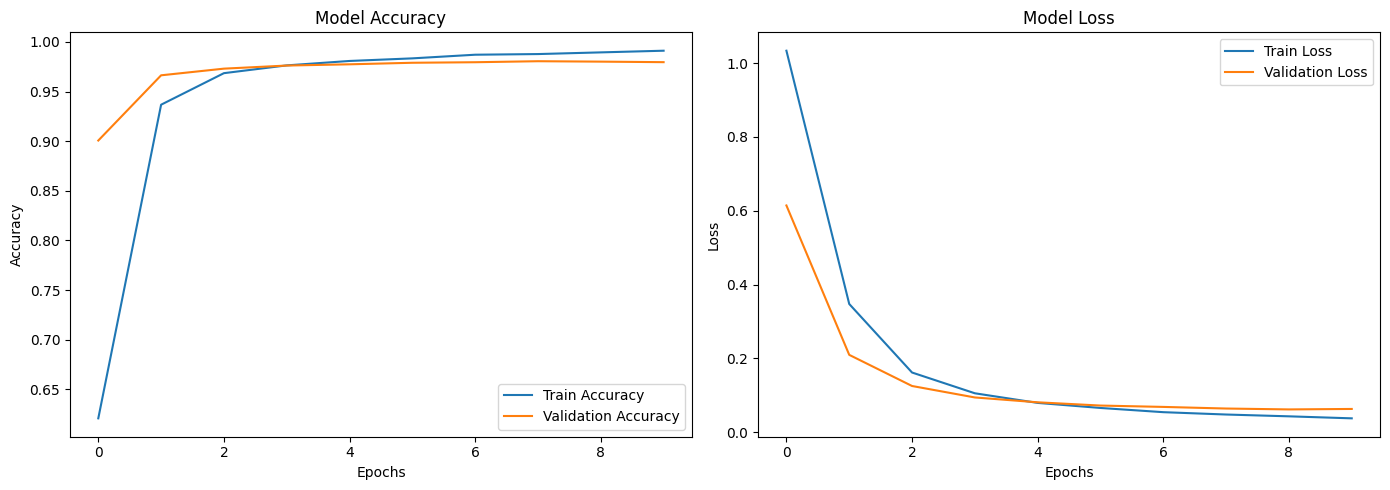

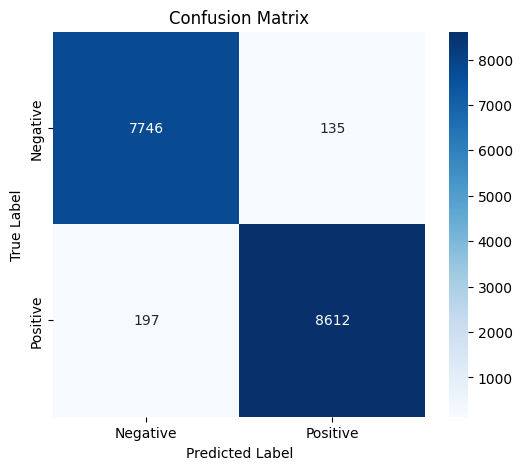

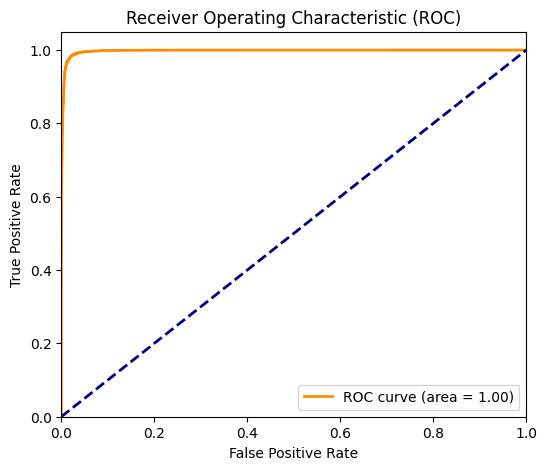

Classification Report:
              precision    recall  f1-score       support
Negative       0.975198  0.982870  0.979019   7881.000000
Positive       0.984566  0.977637  0.981089   8809.000000
accuracy       0.980108  0.980108  0.980108      0.980108
macro avg      0.979882  0.980253  0.980054  16690.000000
weighted avg   0.980143  0.980108  0.980112  16690.000000


In [57]:
# 1. Графики accuracy и loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 4. Отчет о классификации
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).T
print("Classification Report:")
print(report_df)

## Показатели значительно лучше. Модель ожидаемо начинает с низкой точности и высокой потери и затем стабильно улучшается, что видно и на обучающей, и на валидационной выборке. Проблем по типу переобучения уже не наблюдается

In [58]:
model.save('email_spam_detection_model.keras')

## Попробуем использовать ее на деле. Тексты взяты из раздела "спам" моей гугловской почты. Не открывайте ссылки!!! (ну мало ли...)

In [59]:
def make_prediction(text) -> str:
    """
    Функция принимает на вход текст электронного письма на английском языке и возвращает предсказание о том, является ли оно спамом или нет.

    Parameters
    ----------
    text : str
        Строка электронного письма.

    Returns
    -------
    str
        Предсказание с процентом уверенности.
    """
    preprocessed_text = preprocess_text(text)
    tokenized_text = tokenize_emails(preprocessed_text, tokenizer)
    prediction = model.predict(tokenized_text)
    probability = prediction[0][0]

    if probability > 0.5:
        print("Спам! 🚫 (Вероятность: {:.2f}%)".format(probability * 100))
    else:
        print("Не спам! ✅ (Вероятность: {:.2f}%)".format((1 - probability) * 100))


In [60]:
test_text = '''Hello!

I have to share bad news with you. Approximately a few months ago, I gained access to your devices, which you use for internet browsing. After that, I have started tracking your internet activities.

Here is the sequence of events:

Some time ago, I purchased access to email accounts from hackers (nowadays, it is quite simple to buy it online).

I have easily managed to log in to your email account. One week later, I have already installed the Cobalt Strike "Malware" on the Operating Systems of all the devices you use to access your email.

It was not hard at all (since you were following the links from your inbox emails). All ingenious is simple.

This software provides me with access to all your devices controllers (e.g., your microphone, video camera, and all on it).

I have downloaded all your information, data, photos, videos, documents, files, web browsing history to my servers.

I have access to all your messengers, social networks, emails, chat history, and contacts list.

My virus continuously refreshes the signatures (it is driver-based) and hence remains invisible for antivirus software.

Likewise, I guess by now you understand why I have stayed undetected until this letter.

While gathering information about you, I have discovered that you are a big fan of adult websites.'''

make_prediction(test_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Спам! 🚫 (Вероятность: 95.17%)


In [61]:
test_text2 = '''Thank you for registering at Site in English. To Cana корсо nursery Ollada Arlekin - nursery of dogs of breed to Cana corso. Your account is created and must be verified before you can use it.
To verify the account click on the following link or copy-paste it in your browser:
 https://olladaarlekin.com/en/component/users/?task=registration.activate&token=d6e3f42a71bdb36384168c528bff6293

After verification an administrator will be notified to activate your account. You'll receive a confirmation when it's done.
Once that account has been activated you may login to https://olladaarlekin.com/ using the following username and password:

Username: cirlitate1978
Password: AWsJ9K75AN'''
make_prediction(test_text2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Спам! 🚫 (Вероятность: 68.06%)


In [62]:
test_text3 = '''
200+ generative AI models at your fingertips
Hi Vladislav,

Together AI enables you to run inference on 200+ models including chat, image, vision, code/language, rerank, and embeddings models.

Use our OpenAI compatible API in a few lines of code to run the top open-source AI models, including some that we offer completely free:

Try the reasoning capabilities of DeepSeek-R1 Llama 70B distilled (Free!)
Chat with Llama 3.3 70B (Free!)
Create images with FLUX.1 [schnell] (Free!)
Answer questions about images or perform OCR with Llama 3.2 11B (Free!)
Generate code with Qwen 2.5-Coder 32B
It's simple to get started with Python, TypeScript, or REST APIs. For example, in Python:

Python code to use the Together API
To explore all the models, check out our Playground.'''
make_prediction(test_text3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Не спам! ✅ (Вероятность: 89.00%)


## Модель успешно справилась с 3/3 текстами! Первые два были спамом, третий - нет. 